In [20]:
%matplotlib inline
from modsim import *

earth = Condition(thickness = 14140,
                     surface_area = 5.099686589e+14,
                     density = 5510)
earth.radius = sqrt(earth.surface_area / (8 * np.pi))
earth.volume1 = earth.thickness * earth.radius** 2 * np.pi
earth.mass = earth.volume1 * earth.density
print(earth.radius)



baseball = Condition(x = earth.radius / 2.5, 
                      y = (earth.thickness/2) + 1,
                      ay = 9.8,
                      G = 6.67e-11,
                      mass = 145e-3,
                      diameter = 73e-4,
                      rho = 1,
                      C_d = 0.3,
                      angle = 60,
                      velocity = 40,
                      duration = 100)

def make_system(condition):
    """Make a system object.
    
    condition: Condition object with angle, velocity, x, y,
               diameter, duration, g, mass, rho, and C_d
               
    returns: System object
    """
    unpack(condition)
    
    # convert angle to degrees
    theta = np.deg2rad(angle)
    
    # compute x and y components of velocity
    vx, vy = pol2cart(theta, velocity)
    
    # make the initial state
    init = State(x=x, y=y, vx=vx, vy=vy)
    
    # compute area from diameter
    area = np.pi * (diameter/2)**2
    
    # compute timestamps
    ts = linspace(0, duration, 1001)
    
    return System(init=init, G=G, mass=mass, 
                  area=area, rho=rho, C_d=C_d, ts=ts)

def slope_func(state, t, system):
    x, y, vx, vy = state
    unpack(system)
    p = Vector(x, y)
    v = Vector(vx, vy)
    f_grav = p.hat() * (-G * earth.mass * mass / (p.mag**2))
    f_drag = -rho * v.mag * v * C_d * area / 2
    
    #print(f_grav)
    #print(f_grav.mag)
    
    
    
    
    if y > (earth.thickness / 2):
        a_grav = f_grav / mass
        a_y= Vector(0, -ay)
        a_drag = f_drag / mass
    else:
        a_grav = Vector(0, 0)
        a_y = Vector(0, 0)
        a_drag = Vector(0, 0)
    
    a = a_grav + a_y
    a = a_grav + a_drag + a_y


    return vx, vy, a.x, a.y

def find_landing(system):
    counter = 0
    for height in system.results.y:
        if (height < (earth.thickness / 2)):
            #print(system.results.y.index[counter])
            return system.results.y.index[counter]
        counter += 1
        
def interpolate_range(results):
    """Computes the range of the ball when it lands.
    
    results: TimeFrame with x and y
    
    returns: distance in meters
    """
    xs = results.x
    ys = results.y
    t_end = ys.index[-1]
    
    if ys[t_end] > (earth.thickness / 2):
        msg = """The final value of y is still positive;
                 looks like the simulation didn't run
                 long enough."""
        raise ValueError(msg)
        
    t_peak = ys.argmax()
    descent = ys.loc[t_peak:]
    T = interp_inverse(descent, kind='cubic')
    
    t_land = T(earth.thickness / 2)
    X = interpolate(xs, kind='cubic')
    return X(t_land)

def interpolate_time(results):
    """Computes the range of the ball when it lands.
    
    results: TimeFrame with x and y
    
    returns: distance in meters
    """
    xs = results.x
    ys = results.y
    t_end = ys.index[-1]
    
    if ys[t_end] > (earth.thickness / 2):
        msg = """The final value of y is still positive;
                 looks like the simulation didn't run
                 long enough."""
        raise ValueError(msg)
        
    t_peak = ys.argmax()
    descent = ys.loc[t_peak:]
    T = interp_inverse(descent, kind='cubic')
    
    return T(0)

def calc_dist(system):
    range_int = interpolate_range(system.results)
    dist = abs(system.init.x - range_int)
    return dist



4504554.16456


In [21]:
system = make_system(baseball)
system.init

,value
x,1.801822e+06
y,7.071000e+03
vx,2.000000e+01
vy,3.464102e+01


In [22]:
system = make_system(baseball)
run_odeint(system, slope_func)
find_landing(system)

7.1000000000000005

C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


dist is 0.217549417066
dist is 37.0153911338
dist is 286.28750893
dist is 497.471565055
dist is 469.025332321
dist is 353.984095235
dist is 244.791735504
dist is 160.242617178
dist is 97.7139550757
dist is 51.5187789299
dist is 16.9370476035
dist is 9.40470098643
dist is 29.827790225
dist is 45.9312344245
dist is 58.8267523872
dist is 69.2993035944
dist is 77.9120114023
dist is 85.0758752706
dist is 91.0956550575
dist is 96.2008624178
dist is 100.566617375
dist is 104.3282897
dist is 107.591913376
dist is 110.441328095
dist is 112.943471984
dist is 115.152371537
dist is 117.112107268
dist is 118.858552933
dist is 120.421707104
dist is 121.825993148
dist is 123.092466349
dist is 124.238431647
dist is 125.278734205
dist is 126.22594027
dist is 127.090786941
dist is 127.882565652
dist is 128.609272557
dist is 129.277824592
dist is 129.894326671
dist is 130.463937145
dist is 130.991303492
dist is 131.480586887
dist is 131.935374987
dist is 132.358659264
dist is 132.75348164
dist is 133.122

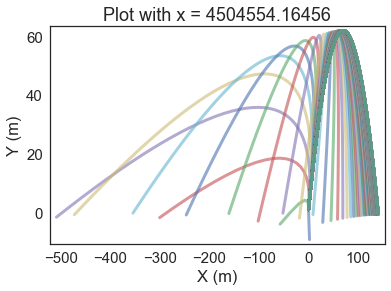

In [26]:
for x in linspace(0, earth.radius, 200):
    
    baseball.x = x
    system = make_system(baseball)
    slope_func(system.init, 0, system)


    run_odeint(system, slope_func)

    xs = system.results.x  - (x)
    ys = system.results.y - (earth.thickness / 2)

    xv = system.results.vx
    yv = system.results.vy

    ground_time = find_landing(system)

    #newfig()
    #plot(xs[:ground_time], label='x')
    #plot(ys[:ground_time], label='y')
    #plot(xv[:ground_time], label='vx')
    #plot(yv[:ground_time], label='vy')
    plot(xs[:ground_time],ys[:ground_time])
    plt.grid()
    decorate(title='Plot with x = ' + str(x),
                xlabel='X (m)',
             ylabel='Y (m)',)
    print("dist is " + str(calc_dist(system)))



dist is 4.974439301


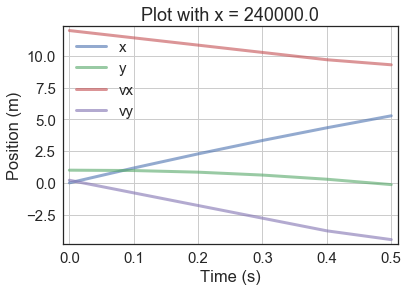

In [6]:
baseball.x = 240000
system = make_system(baseball)
slope_func(system.init, 0, system)


run_odeint(system, slope_func)

xs = system.results.x  - (x)
ys = system.results.y - (earth.thickness / 2)

xv = system.results.vx
yv = system.results.vy

ground_time = find_landing(system)

newfig()

plot(xs[:ground_time], label='x')
plot(ys[:ground_time], label='y')
plot(xv[:ground_time], label='vx')
plot(yv[:ground_time], label='vy')

plt.grid()
decorate(title='Plot with x = ' + str(x),
            xlabel='Time (s)',
         ylabel='Position (m)',)
print("dist is " + str(calc_dist(system)))

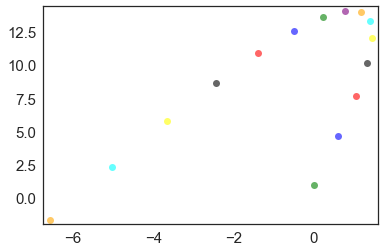

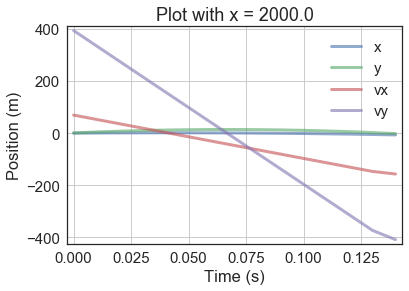

In [7]:
baseball.x = 2000
baseball.angle = 80
baseball.duration = 10
baseball.velocity = 400

system = make_system(baseball)
slope_func(system.init, 0, system)


run_odeint(system, slope_func)


xs = system.results.x  - (x)
ys = system.results.y - (earth.thickness / 2)

xv = system.results.vx
yv = system.results.vy

ground_time = find_landing(system)
xx = xs[:ground_time]
yy = ys[:ground_time]
newfig()

colors = ['green', 'blue', 'red', 'black', 'yellow', 'cyan', 'orange', 'purple']
for i in range(len(xx)):
    plot(xx[i * 0.01], yy[i * 0.01], 'o', color = colors[i % 8])
    
newfig()
plot(xs[:ground_time], label='x')
plot(ys[:ground_time], label='y')
plot(xv[:ground_time], label='vx')
plot(yv[:ground_time], label='vy')

plt.grid()
decorate(title='Plot with x = ' + str(x),
            xlabel='Time (s)',
         ylabel='Position (m)',)

C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


ValueError: The final value of y is still positive;
                 looks like the simulation didn't run
                 long enough.

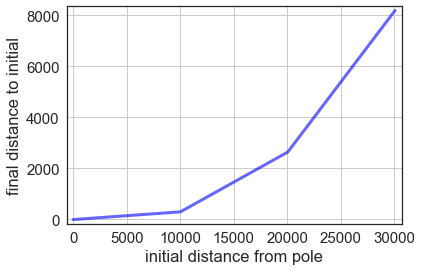

In [19]:
for i in range(10):
    baseball.y += i*100
    
    for x in linspace(0, 5000000, 500):
        baseball.x = x
        
        
        system = make_system(baseball)
        
        run_odeint(system, slope_func)
        plt.grid()

        plot(x, (system.init.x - interpolate_range(system.results)), 'b-')
        decorate(xlabel='initial distance from pole',
                 ylabel='final distance to initial')
       


C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


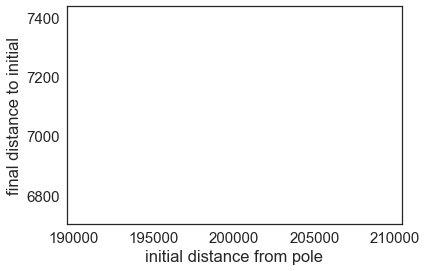

In [15]:
baseball.x = 200000
system = make_system(baseball)
run_odeint(system, slope_func)

plot(baseball.x, baseball.y, 'b-')
decorate(xlabel='initial distance from pole',
                 ylabel='final distance to initial')